# SEM 9 Project

In [ ]:
#Import modules

import os
import re
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import nltk
from nltk import pos_tag, ne_chunk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.tag import StanfordNERTagger
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

## Data frame

In [2]:
#Construct data frame

f_dir = 'config/scratches/YouTube_data.xlsx' #File directory
f = pd.read_excel(f_dir) #Load Excel file with Youtuba data from directory
df = pd.DataFrame(f) #.sort_values(by='replies', ascending=False) #Build data frame
df = df[['uid', 'Comment', 'likes', 'replied to uid', 'replies','type']] #Keep only desired columns
#df= df[0:1000] #Limit df

#Add custom features to dataframe

df['characters'] = df['Comment'].str.replace(' ','').str.len() #Calculated column w. count of characters w/o. spaces
df['words'] = df['Comment'].str.split().str.len() #Calculated column w. count of words 
df['avg_word_length'] = df['characters'] / df['words'] #Calculated column of average word length

#Perform sentiment analysis of each comment

sia = SentimentIntensityAnalyzer() #Instanciate sentiment intesity analyzer
df['sentiment_score'] = df['Comment'].astype(str).apply(sia.polarity_scores) #Apply to comments
df['sentiment_score'] = df['sentiment_score'].apply(lambda x: x['compound']) #Get compound score from sentiment dictionary


#Perform named entity recognition with NLTK & Stanford library

java_path = "Oracle/Java/javapath/java.exe" #Path to local java.exe
os.environ['JAVAHOME'] = java_path #Setup Java environment and point to java.exe path
model = "config/scratches/Stanford nlp/english.all.3class.distsim.crf.ser.gz" #Stanford NER files directories 
jar = "config/scratches/Stanford nlp/stanford-ner.jar" #Stanford NER files directories 


st = StanfordNERTagger(model, jar, encoding='utf-8') #Instantiate Stanford NER tagger
tokenizer = RegexpTokenizer(r"[a-zA-Z]+") #Keep only words
stopWords = stopwords.words('english') #Load english stop words
snowball_stemmer = SnowballStemmer('english') #load stemmer


# tokinze all words, but exclude stop words

df['tok_comment'] = df['Comment'].apply(lambda x: [y for y in tokenizer.tokenize(x) if y.lower() not in stopWords
                                                  and not y.endswith("n't")
                                                  and not y.endswith("'re")
                                                  and y != " "])


def tagger(x): # Function for chunking, in order to avoid memory overloading caused by Java
    a = pd.Series(st.tag_sents(x[:18000]))
    b = pd.Series(st.tag_sents(x[18000:]))
    ab = pd.concat([a,b], ignore_index=True)
    print(ab)
    return ab

df['ner_comment'] = tagger(df['tok_comment']) #Tag all words
df['ner_comment'] = df['ner_comment'].apply(lambda x: list(set([snowball_stemmer.stem(y[0].lower()) 
                                                       for y in x if y[1] != "O"]))) #keep only named entities
df['tok_comment'] = df['tok_comment'].apply(lambda x: [snowball_stemmer.stem(y.lower()) 
                                                       for y in x]) #Now that NER is performed, we can lower and stem each word


df = df[['uid', 'replied to uid', 'type', 'Comment', 'tok_comment', 'ner_comment', 
         'likes', 'replies', 'sentiment_score','characters', 'words', 'avg_word_length']] #Reorder columns


df.columns = ['uid', 'replied_to_uid', 'comment_type', 'comment', 'tok_comment', 'ner_comment', 
              'likes', 'replies', 'sentiment_score','characters', 'words', 'avg_word_length'] #Rename columns

# Pickle data frame, in order to avoid performing this step multiple times

df.to_pickle("./YT_data.pkl") #Pickle data in order to avoid repeating calculating steps
df_pl = pd.read_pickle("./YT_data.pkl") #Un-pickle  data

0        [(name, O), (Connor, PERSON), (android, O), (s...
1        [(robots, O), (feelings, O), (iM, O), (dEvIaNt...
2        [(think, O), (people, O), (become, O), (close,...
3        [(Came, O), (see, O), (many, O), (Detroit, LOC...
4        [(Hello, O), (Sophia, O), (android, O), (sent,...
5        [(would, O), (LOT, O), (less, O), (creepy, O),...
6        [(RA, O), (RA, O), (RA, O), (RA, O), (RA, O), ...
7        [(Feelings, O), (preferances, O), (WENT, O), (...
8        [(W, O), (E, O), (R, O), (E, O), (L, O), (V, O...
9        [(Detroit, LOCATION), (Become, O), (Human, O),...
[46200 rows x 12 columns]


## Sentimental distribution

Positive    20231
Neutral     13135
Negative    12834
Name: sentiment_score, dtype: int64


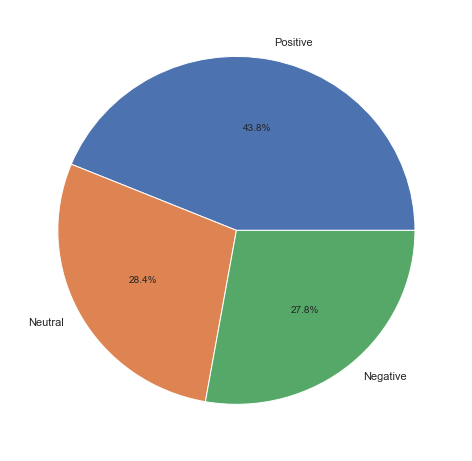

In [3]:
df = pd.read_pickle("./YT_data.pkl")

value_counts = df.sentiment_score.apply(lambda x: "Neutral" if x == 0 else 
                                        ("Positive" if x > 0 else "Negative")).value_counts()
plt.figure(figsize=(8, 8))
pie = plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%')

print(value_counts)

## Comment response

C:\Users\AA\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\AA\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


Sentiment Overview   Negative    Neutral   Positive
likes_vc                                           
Liked               28.277400  28.160803  43.561797
Not Liked           27.408023  28.631865  43.960112
Sentiment Overview   Negative    Neutral   Positive
replies_vc                                         
Not Replied         27.590016  28.802764  43.607220
Replied             29.983571  24.096386  45.920044


C:\Users\AA\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


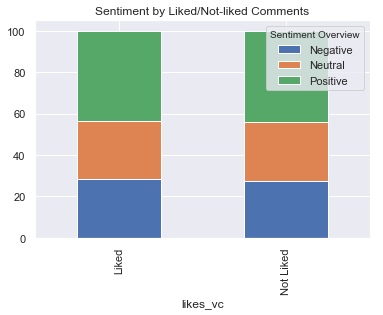

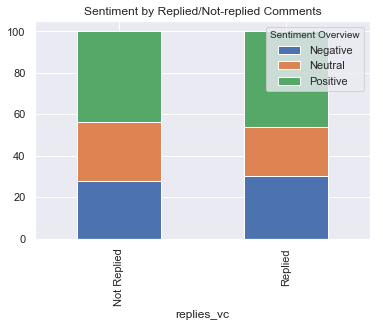

In [20]:
df = pd.read_pickle("./YT_data.pkl")
df.replies = df.replies.fillna(0)
df_numeric = df[['comment_type','likes', 'replies', 'sentiment_score','characters', 'words', 'avg_word_length']]


#EDA of nummeric data
df.replies = df.replies.fillna(0)
df_numeric = df[['likes', 'replies', 'sentiment_score','characters', 'words', 'avg_word_length']]


df_numeric['likes_vc'] = df_numeric['likes'].apply(lambda x: "Liked" if x > 0 else 
                                                   "Not Liked")
df_numeric['replies_vc'] = df_numeric['replies'].apply(lambda x: "Replied" if x > 0 else 
                                                       "Not Replied")

"""
df_numeric['replies_likes_vc'] = df_numeric.apply(lambda x: "Replied and Liked" if x['likes'] > 0 and x['replies'] > 0 else 
                                                       "Neither Replied nor Liked")
                                                       
"""
df_numeric['Sentiment Overview'] = df_numeric.sentiment_score.apply(lambda x: "Neutral" if x == 0 else 
                                                              ("Positive" if x > 0 else "Negative"))


like_sentiment = pd.crosstab(df_numeric['likes_vc'], df_numeric['Sentiment Overview'])
reply_sentiment = pd.crosstab(df_numeric['replies_vc'], df_numeric['Sentiment Overview'])

like_sentiment_pct = like_sentiment.div(like_sentiment.sum(1).astype(float), axis=0) * 100
reply_sentiment_pct = reply_sentiment.div(reply_sentiment.sum(1).astype(float), axis=0) * 100
print(like_sentiment_pct)
print(reply_sentiment_pct)


like_sentiment_pct.plot(kind='bar', 
                   stacked=True, 
                   title='Sentiment by Liked/Not-liked Comments')
reply_sentiment_pct.plot(kind='bar', 
                   stacked=True, 
                   title='Sentiment by Replied/Not-replied Comments')


## Named entities

In [61]:
df_pl = pd.read_pickle("./YT_data.pkl")
df= df_pl

d = {}
for num, row in enumerate(df.ner_comment):
    for word in row:
        if word not in d.keys():
            d.update({word: (df.iloc[num]['sentiment_score'],1)})
        else:
            d[word] = ( sum([d[word][0],df.iloc[num]['sentiment_score']]), d[word][1]+1 )
#print(d)
            
df1 = pd.DataFrame(d).T.sort_values(by=0, ascending=False)
df1.columns = ['sentiment', 'occurrence']

df1 = df1[(df1.occurrence.between(10,900)) & (df1.sentiment != 0)]

df1 = df1.iloc[np.r_[0:100, -100:0]]
df1['ratio'] = df1.sentiment / df1.occurrence
#df1.to_csv('csv.csv')
print(df1.to_string())



            sentiment  occurrence     ratio
sam          103.3667       450.0  0.229704
elon          80.6324       567.0  0.142209
googl         65.2609       315.0  0.207177
musk          59.6691       282.0  0.211593
harri         54.5637       320.0  0.170512
intellig      51.7442       100.0  0.517442
agi           47.9309       141.0  0.339935
earth         43.0850       140.0  0.307750
sophia        40.1381       160.0  0.250863
stephen       37.6622       127.0  0.296553
jame          28.0664       137.0  0.204864
watson        26.3835       104.0  0.253688
joe           26.0978       173.0  0.150854
jesus         26.0115       194.0  0.134080
cameron       23.9800       122.0  0.196557
ibm           23.9021        80.0  0.298776
facebook      23.7920       138.0  0.172406
kurzweil      23.1771        67.0  0.345927
artifici      21.4284        51.0  0.420165
microsoft     19.4324        69.0  0.281629
hawk          19.4122       110.0  0.176475
neil          19.2236        94.

## NER dictionary

In [19]:
#print(df_tb)
df_pl = pd.read_pickle("./YT_data.pkl")
df= df_pl

d = {}
for num, row in enumerate(df.ner_comment):
    for word in row:
        if word not in d.keys():
            d.update({word: (df.iloc[num]['sentiment_score'],1)})
        else:
            d[word] = ( sum([d[word][0],df.iloc[num]['sentiment_score']]), d[word][1]+1 )
            
df1 = pd.DataFrame(d).T.sort_values(by=0, ascending=False)
df1.columns = ['sentiment', 'occurrence']
df1 = df1[(df1.occurrence.between(10,900)) & (df1.sentiment != 0)]

## NMF Topics

In [52]:
#LDA function

def topicFunc(dfData):
    #2000
    tfidfvect = TfidfVectorizer(max_features=10000, ngram_range=(1,1), max_df=0.65, min_df=3, stop_words="english", token_pattern=r"[A-Za-z']+")
    vect = tfidfvect
    
    nmf = NMF(n_components=30, tol=0.00001, max_iter=200, init='random', random_state=25, l1_ratio=1)
    model = nmf
    
    X = vect.fit_transform(dfData)
    model.fit_transform(X)
    feature_names = np.array(vect.get_feature_names())
  
    for topic, comp in enumerate(model.components_):
        topic_words = {}
        word_idx = np.argsort(comp)[::-1][:20]
        topic_words[topic] = [feature_names[i] for i in word_idx]
 
        for topic, words in topic_words.items():
            topic += 1
            print('Topic: %d' % topic)
            print('  %s' % ', '.join(words))

   
    
df_pl = pd.read_pickle("./YT_data.pkl")
df= df_pl

topicFunc(df.tok_comment.apply(' '.join))



Topic: 1
  make, sens, decis, better, feel, tri, money, sure, pleas, mistak, choic, stop, great, movi, let, smarter, u, smart, sandwich, someon
Topic: 2
  comput, quantum, program, brain, power, learn, code, use, process, physic, softwar, run, scienc, abl, neuron, simul, algorithm, data, faster, programm
Topic: 3
  peopl, job, kill, mani, zoo, world, money, govern, smart, fear, stupid, lot, work, problem, evil, tell, alway, white, believ, tri
Topic: 4
  human, becom, destroy, detroit, race, kill, end, better, speci, extinct, brain, emot, smarter, threat, harm, earth, planet, war, decid, machin
Topic: 5
  funnel, vision, cool, awesom, cozmo, guy, shawn, cute, cosmo, hi, best, awsom, wish, vid, christma, u, channel, funni, fan, hes
Topic: 6
  good, point, bad, realli, idea, job, guy, luck, look, evil, pretti, argument, work, movi, explan, quit, morn, film, feel, question
Topic: 7
  ai, program, creat, develop, kill, danger, control, learn, self, general, fear, problem, futur, goal, build